In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import datetime
#from cassandra.cluster import Cluster
import CovidAPI 

In [2]:
api = CovidAPI.API()
data = api.getWorld()

print(len(data))

195


In [3]:
ConfirmedCases = np.zeros((len(data)))

for i in range(len(data)):
    ConfirmedCases[i] = data[i]["TotalConfirmed"]

ConfirmedCases = np.sort(ConfirmedCases)


Train = ConfirmedCases[:-14]
Val = ConfirmedCases[-28:-7]
Test = ConfirmedCases[-21:]


x_train = np.zeros((167, 1, 14))
y_train = np.zeros((167, 1))
x_val = np.zeros((7, 1, 14))
y_val = np.zeros((7, 1))
x_test = np.zeros((7, 1, 14))
y_test = np.zeros((7, 1))


for i in range(Train.shape[0] - 14):
    x_train[i] = Train[i:i+14]
    y_train[i] = Train[i+14]


for i in range(Val.shape[0] - 14):
    x_val[i] = Val[i:i+14]
    y_val[i] = Val[i+14]


for i in range(Test.shape[0] - 14):
    x_test[i] = Test[i:i+14]
    y_test[i] = Test[i+14]



In [4]:
'''
! ls
data = np.load("CountryCases.npy", allow_pickle=True, encoding='bytes')

X = np.zeros((36124, 1, 14))
Y = np.zeros((36124, 1, 1))

index = 0

for i, country in enumerate(data):
    for j in range(len(country) - 14):
        X[index] = country[j:j+14]
        Y[index] = country[j+14]
        index +=1
        
print(index)
print(X.shape, Y.shape)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
'''

'\n! ls\ndata = np.load("CountryCases.npy", allow_pickle=True, encoding=\'bytes\')\n\nX = np.zeros((36124, 1, 14))\nY = np.zeros((36124, 1, 1))\n\nindex = 0\n\nfor i, country in enumerate(data):\n    for j in range(len(country) - 14):\n        X[index] = country[j:j+14]\n        Y[index] = country[j+14]\n        index +=1\n        \nprint(index)\nprint(X.shape, Y.shape)\n\nx_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)\n\nprint(x_train.shape, x_test.shape, y_train.shape, y_test.shape)\n'

In [5]:
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, GaussianNoise, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.losses import mean_squared_error
import keras
import tensorflow.keras.backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

Using TensorFlow backend.


In [8]:
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model, Sequential

tf.keras.backend.clear_session()

#model = Sequential()
#model.add()
#model.add(LSTM(14, input_shape=(dim), return_sequences=True, stateful=False))
#model.add(LSTM(20, input_shape=(dim), return_sequences=False, stateful=False))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mse', optimizer='adam')

# model = Sequential()
# model.add(LSTM(14, activation='relu', return_sequences=True, input_shape=(dim,1)))
# model.add(LSTM(14, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1, activation='linear'))

#define the learning rate
# optimizer = keras.optimizers.Adam(lr=learning_rate)

#compile model
# model.compile(optimizer=optimizer, loss='mae')

input_layer = Input(shape=(14))
dense1 = Dense(60, activation='relu')(input_layer)
dense2 = Dense(100, activation='relu')(dense1)
dense3 = Dense(100, activation='relu')(dense2)
dense4 = Dense(100, activation='relu')(dense3)
dense5 = Dense(100, activation='relu')(dense4)
dense6 = Dense(100, activation='relu')(dense5)
dropout_layer = Dropout(0.2)(dense6)
output_layer = Dense(1, activation='linear')(dropout_layer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00001,
    decay_steps=100,
    decay_rate=0.9)

boundaries = [100, 250]
values = [0.00001, 0.000001, 0.0000001]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
step = tf.Variable(0, trainable=False)
learning_rate = learning_rate_fn(step)

#optimizer = tf.keras.optimizers.Adam(lr=0.000001)
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), optimizer=optimizer)
model.summary()

model.fit(x_train, y_train, batch_size=5, epochs=1500,
          validation_data=(x_test, y_test), shuffle=True, callbacks=[callback])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                900       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100 

34/34 [==============================] - 0s 5ms/step - loss: 9.0373 - val_loss: 2.7148
Epoch 61/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.4911 - val_loss: 2.1480
Epoch 62/1500
34/34 [==============================] - 0s 6ms/step - loss: 9.2847 - val_loss: 2.8081
Epoch 63/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.7175 - val_loss: 3.5661
Epoch 64/1500
34/34 [==============================] - 0s 5ms/step - loss: 8.6885 - val_loss: 4.0407
Epoch 65/1500
34/34 [==============================] - 0s 6ms/step - loss: 10.0276 - val_loss: 3.9334
Epoch 66/1500
34/34 [==============================] - 0s 5ms/step - loss: 8.6470 - val_loss: 3.2735
Epoch 67/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.7011 - val_loss: 2.6641
Epoch 68/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.1434 - val_loss: 4.0622
Epoch 69/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.3814 - val_loss: 4.0750
Epo

Epoch 141/1500
34/34 [==============================] - 0s 5ms/step - loss: 8.9492 - val_loss: 3.0392
Epoch 142/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.1657 - val_loss: 3.0625
Epoch 143/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.8675 - val_loss: 2.6673
Epoch 144/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.1043 - val_loss: 2.7529
Epoch 145/1500
34/34 [==============================] - 0s 4ms/step - loss: 8.8506 - val_loss: 2.2574
Epoch 146/1500
34/34 [==============================] - 0s 5ms/step - loss: 8.4198 - val_loss: 0.8822
Epoch 147/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.5420 - val_loss: 2.0587
Epoch 148/1500
34/34 [==============================] - 0s 5ms/step - loss: 8.2748 - val_loss: 2.1751
Epoch 149/1500
34/34 [==============================] - 0s 6ms/step - loss: 7.9999 - val_loss: 2.8117
Epoch 150/1500
34/34 [==============================] - 0s 5ms/step - loss: 9.1071

34/34 [==============================] - 0s 5ms/step - loss: 7.8228 - val_loss: 1.7554
Epoch 222/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.5087 - val_loss: 1.4189
Epoch 223/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.8930 - val_loss: 2.7802
Epoch 224/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.0474 - val_loss: 2.3633
Epoch 225/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.8197 - val_loss: 2.7387
Epoch 226/1500
34/34 [==============================] - 0s 5ms/step - loss: 8.5931 - val_loss: 2.4094
Epoch 227/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.8172 - val_loss: 2.1816
Epoch 228/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.7529 - val_loss: 2.2453
Epoch 229/1500
34/34 [==============================] - 0s 5ms/step - loss: 7.4671 - val_loss: 1.2922
Epoch 230/1500
34/34 [==============================] - 0s 5ms/step - loss: 8.4446 - val_loss: 1.

In [72]:
model.save("Models/model_1/model_1")
model.save_weights('Models/model_1_weights/model_1_weights')

INFO:tensorflow:Assets written to: Models/model_1/model_1/assets


In [19]:
x = x_test[-1].reshape(1,1,14)
y_pred = np.zeros((14))

for i in range(14):
    print(x[0, 0])
    print()
    pred = int(model.predict(x)[0, 0])
    y_pred[i] = pred
    x = np.delete(x, 0, 2)
    x = np.insert(x, 13, pred, 2)
    print("pred", pred)
    print()
    

[37468956. 37795152. 38123357. 38504630. 38911224. 39322523. 39664028.
 39948934. 40388802. 40776671. 40949395. 41220369. 41269272. 41688829.]

pred 42552932

[37795152. 38123357. 38504630. 38911224. 39322523. 39664028. 39948934.
 40388802. 40776671. 40949395. 41220369. 41269272. 41688829. 42552932.]

pred 42863252

[38123357. 38504630. 38911224. 39322523. 39664028. 39948934. 40388802.
 40776671. 40949395. 41220369. 41269272. 41688829. 42552932. 42863252.]

pred 43188144

[38504630. 38911224. 39322523. 39664028. 39948934. 40388802. 40776671.
 40949395. 41220369. 41269272. 41688829. 42552932. 42863252. 43188144.]

pred 43626524

[38911224. 39322523. 39664028. 39948934. 40388802. 40776671. 40949395.
 41220369. 41269272. 41688829. 42552932. 42863252. 43188144. 43626524.]

pred 44101708

[39322523. 39664028. 39948934. 40388802. 40776671. 40949395. 41220369.
 41269272. 41688829. 42552932. 42863252. 43188144. 43626524. 44101708.]

pred 44559656

[39664028. 39948934. 40388802. 40776671. 40949

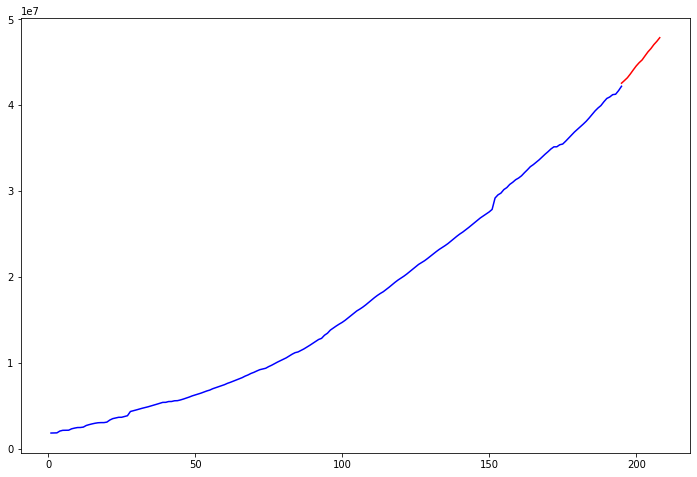

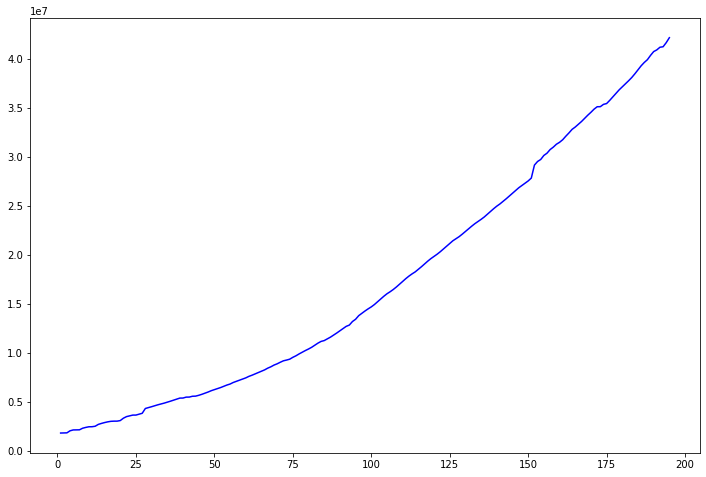

In [21]:
length = len(ConfirmedCases)

xAx = np.arange(1, length+1)
xAx2 = np.arange(length, length+14)
plt.figure(figsize=((12, 8)))
plt.plot(xAx, ConfirmedCases, color='blue')
plt.plot(xAx2, y_pred, color='red')
plt.show()

plt.figure(figsize=((12, 8)))
plt.plot(xAx, ConfirmedCases, color='blue')
plt.show()